In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import copy

import seaborn as sns
from matplotlib import pyplot as plt

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from collections import OrderedDict

GPU: False
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/datasets/fashion-mnist_train.csv")

label_dict = {0:'top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle'}

class_num = len(label_dict)

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

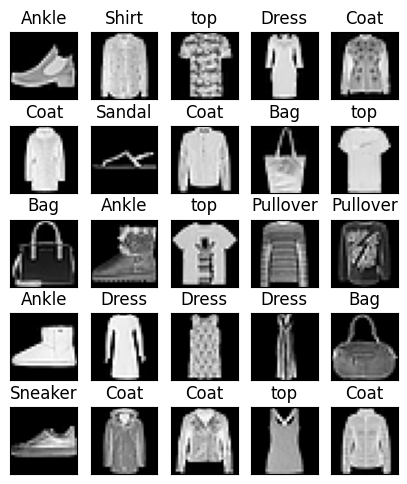

In [91]:
r = 5
c = 5
fig=plt.figure(figsize=(r, c*1.2), dpi=100)
for i in range(1, r*c+1):
    img = X[i].reshape(28,28)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(label_dict[Y[i]])
    
    plt.imshow(img,cmap='gray')
plt.show()

In [92]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [93]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [94]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [95]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [96]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(784,256)
        self.linear2 = nn.Linear(256,100)
        self.linear3 = nn.Linear(100,64)
        self.linear4 = nn.Linear(64,10)
    
    def forward(self,X):
        X1 = F.relu(self.linear1(X))
        X2 = F.relu(self.linear2(X1))
        X3 = F.relu(self.linear3(X2))
        X4 = self.linear4(X3)
        return X1, X2, X3, F.log_softmax(X4, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()
    
print(mlp)    

Model(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)


In [97]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [98]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)[3]
    loss = F.cross_entropy(output,val_y)
    return loss

In [99]:
%%time
EPOCHS = 10

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()
            
        optimizer.zero_grad()
        
        _, _, _, y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())
        
        loss.backward()
        optimizer.step()
        
        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.683887243270874 | val_loss: 0.7050036787986755
Epoch: 2 | loss: 0.5197817087173462 | val_loss: 0.5298317670822144
Epoch: 3 | loss: 0.4646727740764618 | val_loss: 0.48329171538352966
Epoch: 4 | loss: 0.4352404773235321 | val_loss: 0.45598262548446655
Epoch: 5 | loss: 0.41016244888305664 | val_loss: 0.4339776635169983
Epoch: 6 | loss: 0.39352279901504517 | val_loss: 0.41870683431625366
Epoch: 7 | loss: 0.38013148307800293 | val_loss: 0.40680554509162903
Epoch: 8 | loss: 0.3704954981803894 | val_loss: 0.39386385679244995
Epoch: 9 | loss: 0.36042818427085876 | val_loss: 0.3801342844963074
Epoch: 10 | loss: 0.35584691166877747 | val_loss: 0.3698708117008209
CPU times: user 2min 57s, sys: 189 ms, total: 2min 57s
Wall time: 2min 58s


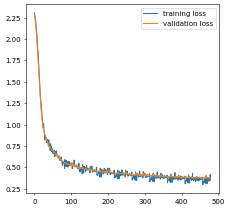

In [100]:
plt.figure(figsize=(5,5),dpi=50)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [101]:
def predict(model,val_x,ret_fm=False):
    """
    ret_fm: when set True, return feature map of layers
    """
    if cuda: val_x = val_x.cuda()
    out = model(val_x)
   
    ret = []
    y_preds = []
    if(ret_fm == False):
        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
        
        ret = y_preds
    else:
        f1 = out[0].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 256
        f2 = out[1].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 100
        f3 = out[2].data.detach().cpu().numpy().reshape(val_x.shape[0], -1)   # 12000 * 64

        _, preds = torch.max(out[3].data,1)
        for p in preds: y_preds.append(p.detach().cpu().numpy().item())
            
        ret = (f1, f2, f3, y_preds)
    
    return ret

In [102]:
pred = predict(mlp,val_x)

Accuracy: 86.8 %


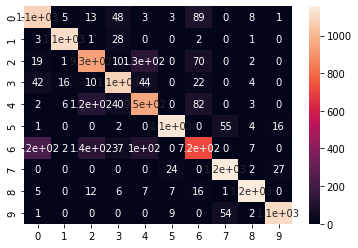

In [103]:
cm = confusion_matrix(val_y.numpy(), pred)

plt.figure()
sns.heatmap(cm,annot=True)

print("Accuracy:",accuracy_score(val_y.numpy(),pred)*100,"%")

tensor(0)


Text(0.5, 1.0, 'fm of layer2')

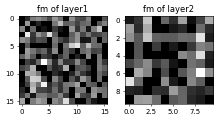

In [104]:
sp1 = val_x[0, :].reshape(1,-1)   # take one sample from validation set [1, 784]

res1 = predict(mlp,sp1,ret_fm=True)   # then make a prediction

print(val_y[0])  # true lable of the sample

plt.figure(figsize=(5, 3), dpi=50)
plt.subplot(121)
plt.imshow(res1[0].reshape(16, 16), cmap='gray')
plt.title("fm of layer1")
plt.subplot(122)
plt.imshow(res1[1].reshape(10, 10), cmap='gray')
plt.title("fm of layer2")

In [105]:
# begin testing
pred = predict(mlp, val_x, ret_fm=True)    # return (f1, f2, f3, y_preds)
pred[0].shape, pred[1].shape, pred[2].shape

((12000, 256), (12000, 100), (12000, 64))

Each layer generates either of the two feature maps: 

1. **positive** feature map(on the correctly classified sample)
2. **negative** feature map(on the mis-classified sample)

i.e. for any class $c$ we have:
$$\bar x_{pos,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{pos,c}^{(m)}$$
and
$$\bar x_{neg,c} = \frac{1}{M}\sum^{m}_{M}\sum_{k=0}^{K}x_{neg,c}^{(m)}$$

In [106]:
layer_num = len(pred) - 1

In [107]:
target = val_y.numpy()
y_pred = pred[-1]

benchmarks = dict()
for l in range(layer_num):      # for all layers
    benchmarks[l] = {'pos':None, 'neg':None}     # feature map dict {layer0: {pos_dict, neg_dict}, layer1:{},,,}
    
    current_layer_fm = pred[l]                    # size: 12000*256
    pos_dict = dict()               # {'0': (numpy(1*256), t)}  t is the times '0' is visited
    neg_dict = dict()
    for i in range(current_layer_fm.shape[0]):    # for all samples
        if(y_pred[i] == target[i]):
            if target[i] not in pos_dict:   # if the first time
                pos_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = pos_dict[target[i]][1]
                pos_dict[target[i]] = (pos_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                pos_dict[target[i]][1] += 1
        else:
            if target[i] not in neg_dict:
                neg_dict[target[i]] = (current_layer_fm[i], 1)
            else:
                t = neg_dict[target[i]][1]
                neg_dict[target[i]] = (neg_dict[target[i]][0] * t + current_layer_fm[i]) / (t + 1)
                neg_dict[target[i]][1] += 1
    
    benchmarks[l]['pos'] = pos_dict
    benchmarks[l]['neg'] = neg_dict

In [108]:
def distance(benchmark, feature_map, method='L2', norm=True):
    """
    calculate the similarity between benchmark and a feature map
    """

    benchmark = benchmark.reshape(-1, 1)
    feature_map = feature_map.reshape(-1, 1)

    if norm is True:
        scaler = StandardScaler()
        benchmark = scaler.fit_transform(benchmark)
        feature_map = scaler.fit_transform(feature_map)

    if method == 'L2':
        return np.linalg.norm(benchmark - feature_map)
    
    raise Exception("No designated method found.")

class 0, layer 0, sim: 0.101815
class 0, layer 1, sim: 0.182946
class 0, layer 2, sim: 0.229194
class 1, layer 0, sim: 0.099460
class 1, layer 1, sim: 0.183299
class 1, layer 2, sim: 0.184949
class 2, layer 0, sim: 0.141468
class 2, layer 1, sim: 0.229051
class 2, layer 2, sim: 0.359548
class 3, layer 0, sim: 0.076633
class 3, layer 1, sim: 0.152520
class 3, layer 2, sim: 0.192312
class 4, layer 0, sim: 0.090033
class 4, layer 1, sim: 0.201854
class 4, layer 2, sim: 0.329646
class 5, layer 0, sim: 0.067637
class 5, layer 1, sim: 0.147250
class 5, layer 2, sim: 0.208438
class 6, layer 0, sim: 0.100896
class 6, layer 1, sim: 0.174364


<ipython-input-109-2a5105cca28f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 1), dpi=50)


class 6, layer 2, sim: 0.261542
class 7, layer 0, sim: 0.155974
class 7, layer 1, sim: 0.322714
class 7, layer 2, sim: 0.396181
class 8, layer 0, sim: 0.065499
class 8, layer 1, sim: 0.127170
class 8, layer 2, sim: 0.163216
class 9, layer 0, sim: 0.070770
class 9, layer 1, sim: 0.168445
class 9, layer 2, sim: 0.245397


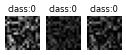

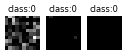

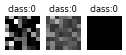

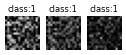

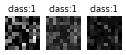

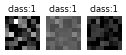

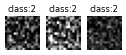

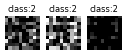

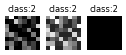

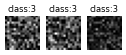

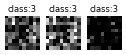

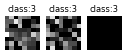

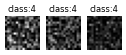

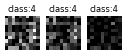

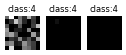

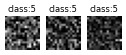

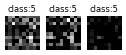

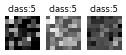

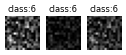

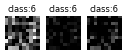

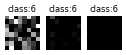

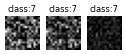

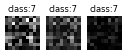

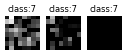

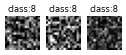

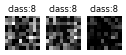

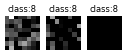

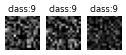

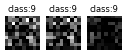

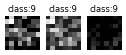

In [109]:
for c in range(class_num):
    for l in range(layer_num):
        fig = plt.figure(figsize=(3, 1), dpi=50)

        pos_bm = benchmarks[l]['pos'][c]
        neg_bm = benchmarks[l]['neg'][c]

        pos_bm = pos_bm.reshape(int(np.sqrt(len(pos_bm))), -1)
        neg_bm = neg_bm.reshape(int(np.sqrt(len(neg_bm))), -1)
        diff_bm = np.abs(np.subtract(pos_bm, neg_bm))

        imgs = [pos_bm, neg_bm, diff_bm]

        sim = 1 / distance(pos_bm, neg_bm, 'L2')

        for i, img in enumerate(imgs):
            plt.subplot(1,3,i+1)
            plt.axis('off')
            plt.title('class:' + str(c))
            plt.imshow(img, cmap='gray')
            plt.clim(np.min(pos_bm), np.max(pos_bm))
        
        print('class %d, layer %d, sim: %f' % (c, l, sim))

In [110]:
y_pred_flat = np.array(y_pred).reshape(1, -1)[0]
y_pred_flat

array([4, 2, 2, ..., 0, 1, 7])

In [111]:
val_y

tensor([0, 2, 2,  ..., 0, 1, 7])

- TODO: count similarities on all sample data, find a threshold

In [125]:
%%time
# init dict
dsb = dict()    # distribution dict
for l in range(layer_num):
    pos_dict = dict()
    neg_dict = dict()
    for c in range(class_num):
        pos_dict[c] = []
        neg_dict[c] = []
    dsb[l] = {'pos': pos_dict, 'neg': neg_dict}

for i in range(val_x.shape[0]):
    pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)
    y_pred = pred[-1][0]
    target = int(val_y[i].numpy())

    for l in range(layer_num):  # compare on each layer
        bench_fm = benchmarks[l]['pos'][target]    # there're two benchmarks, only take positive one since it's meaningful
        fm = pred[l]

        sim = 1 / distance(bench_fm, fm, method='L2')

        if y_pred == target:
            dsb[l]['pos'][target].append(sim)
        else:
            dsb[l]['neg'][target].append(sim)

CPU times: user 32.6 s, sys: 123 ms, total: 32.7 s
Wall time: 34.1 s


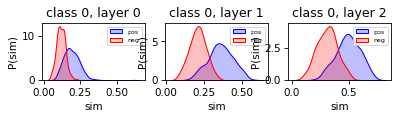

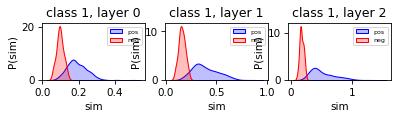

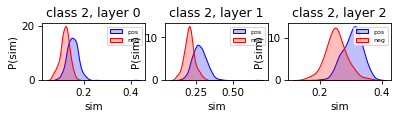

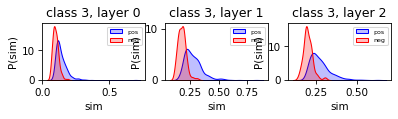

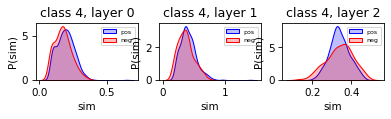

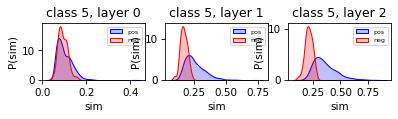

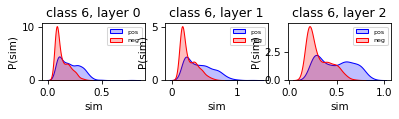

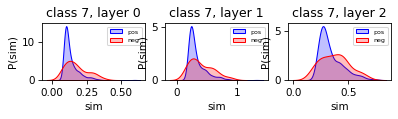

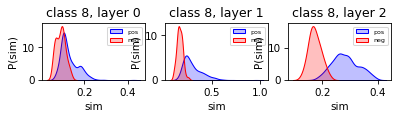

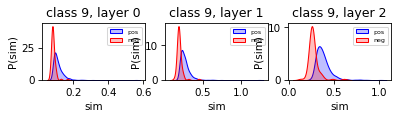

In [126]:
for c in range(class_num):
    fig = plt.figure(figsize=(6, 1), dpi=75)
    for l in range(layer_num):
        
        pos_data = dsb[l]['pos'][c]
        neg_data = dsb[l]['neg'][c]
        
        plt.subplot(1, layer_num, l+1)
        ax = sns.kdeplot(pos_data, color="Blue", fill = True)
        ax = sns.kdeplot(neg_data, ax=ax, color="Red", fill= True)
        ax.legend(["pos","neg"],loc='upper right',prop={'size': 6})
        ax.set_ylabel('P(sim)')
        ax.set_xlabel('sim')
        ax.set_title('class %d, layer %d' % (c, l))

&emsp;&emsp; We can see from the kernel density distribution plots above that for most classes negative samples(red) are subjected to a different distribution from that of the positive samples. They tend to have a lower density.

&emsp;&emsp; Beware, if we change similarity metrics or normalization, the results might be different.

In [214]:
correct_list = [0] * class_num
counter_list = [0] * class_num
for i in range(len(val_y)):
    counter_list[val_y[i]] += 1
    if(val_y[i] == y_pred_flat[i]):
        correct_list[val_y[i]] += 1

for i in range(class_num):
    print('class %d acc: %f' % (i, correct_list[i] / counter_list[i]))

class 0 acc: 0.863891
class 1 acc: 0.969459
class 2 acc: 0.798456
class 3 acc: 0.886792
class 4 acc: 0.792154
class 5 acc: 0.935802
class 6 acc: 0.586263
class 7 acc: 0.956126
class 8 acc: 0.955261
class 9 acc: 0.943541


Note: Take out those neg samples with large sim -> how are they classified to pos sample?

Note: take 1 neg with very large sim and 1 pos

4 kinds of images: pos+sim, pos-sim, neg+sim, neg-sim

find 5 pics for each

In [115]:
obs_l = 0   # layer in observance
obs_c = 6   # class in observance

Q1_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.25)
Q3_pos = np.quantile(dsb[obs_l]['pos'][obs_c], 0.75)
Q1_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.25)
Q3_neg = np.quantile(dsb[obs_l]['neg'][obs_c], 0.75)

imobs_dict = {'pos_Q1': [], 'pos_Q3': [], 'neg_Q1': [], 'neg_Q3': []}
for i in range(val_x.shape[0]):
    if(int(val_y[i]) == obs_c):     # only class in observance will be picked up       
        pred = predict(mlp, val_x[i, :].reshape(1,-1), ret_fm=True)

        y_pred = pred[-1][0]
        target = obs_c

        fm = pred[obs_l]
        benchmark = benchmarks[obs_l]['pos'][obs_c]
        sim = 1 / distance(benchmark, fm)

        if(y_pred == target):   # pos
            if(sim < Q1_pos and len(imobs_dict['pos_Q1']) < 5):
                imobs_dict['pos_Q1'].append(i)  # put index
            elif(sim > Q3_pos and len(imobs_dict['pos_Q3']) < 5):
                imobs_dict['pos_Q3'].append(i)
        else:
            if(sim < Q1_neg and len(imobs_dict['neg_Q1']) < 5):
                imobs_dict['neg_Q1'].append(i)  # put index
            elif(sim > Q3_neg and len(imobs_dict['neg_Q3']) < 5):
                imobs_dict['neg_Q3'].append(i)
        
        # found 5 imgs for 4 types, exit
        if(len(imobs_dict['pos_Q1']) == 5 and len(imobs_dict['pos_Q3']) == 5 and 
           len(imobs_dict['neg_Q1']) == 5 and len(imobs_dict['neg_Q3']) == 5):
           break

if(len(imobs_dict['pos_Q1']) != 5 or len(imobs_dict['pos_Q3']) != 5 or 
   len(imobs_dict['neg_Q1']) != 5 or len(imobs_dict['neg_Q3']) != 5):
   raise  Exception("Fetch images failed.")

The first row are the images that are classified correctly but have a low similarity with the benchmark of the class.

The second row are the images classified correctly whose similarity is higher than 75% of total samples.

The third row images are misclassified and has a low similarity to benchmark.

The forth row images are misclassified but has a high similarity to benchmark.

The 2nd row looks really eriee... how are these clothes shirts??? They could look like anything(e.g. shirt, coat...) but shirts. NO wonders the network can not gain a high acc..

class 6: Shirt, layer 0


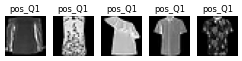

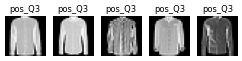

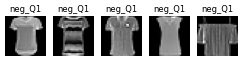

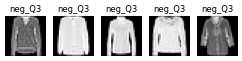

In [116]:
print('class %d: %s, layer %d' % (obs_c, label_dict[obs_c], obs_l))
for key in list(imobs_dict.keys()):
    fig = plt.figure(dpi=50)
    for i, index in enumerate(imobs_dict[key]):
        img = val_x[index].reshape(int(np.sqrt(len(val_x[index]))), -1)
        plt.subplot(1,5,i+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')
        plt.title(key)

In [159]:
def trace(x, target, benchmarks, prt=False):
    """
    x: a sample, input image
    target: true label of this sample
    """
    pred = predict(mlp, x, True)
    if(prt): print("pred label: " + str(pred[-1][0]))

    traces = []
    for l in range(len(pred) - 1):
        fm = pred[l]                    # feature map on current layer
        bms = [benchmarks[l]['pos'][i] for i in range(len(benchmarks[l]['pos']))]
        sims = [round(1 / distance(bm, fm, 'L2'), 6) for bm in bms]
        traces.append(np.argmax(sims))
        if(prt): print(sims)
    
    return traces

In [129]:
imobs_dict['pos_Q1'], imobs_dict['pos_Q3'], imobs_dict['neg_Q1'], imobs_dict['neg_Q3']

([33, 122, 325, 355, 378],
 [164, 198, 211, 282, 323],
 [6, 48, 214, 608, 626],
 [72, 101, 169, 181, 208])

In [135]:
trace(val_x[122, :].reshape(1,-1), 6, benchmarks, prt=True)

pred label: 6
[0.146458, 0.109038, 0.087287, 0.096825, 0.083863, 0.047151, 0.085264, 0.05095, 0.062008, 0.051625]
[0.293899, 0.178783, 0.197299, 0.150653, 0.163656, 0.078699, 0.174303, 0.07927, 0.10775, 0.078259]
[0.411561, 0.185087, 0.232411, 0.186688, 0.201479, 0.095162, 0.227334, 0.090772, 0.125415, 0.090887]


[0, 0, 0]

0.036725248853754444


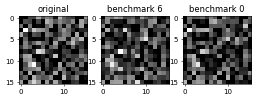

In [131]:
plt.figure(dpi=50)

plt.subplot(1,3,1)
plt.title('original')
plt.imshow(predict(mlp, val_x[122, :].reshape(1,-1), True)[0].reshape(16, 16), cmap='gray')

plt.subplot(1,3,2)
plt.title('benchmark 6')
plt.imshow(benchmarks[0]['pos'][6].reshape(16, 16), cmap='gray')

plt.subplot(1,3,3)
plt.title('benchmark 0')
plt.imshow(benchmarks[0]['pos'][0].reshape(16, 16), cmap='gray')

print(1 / np.linalg.norm(benchmarks[0]['pos'][6] - predict(mlp, val_x[68, :].reshape(1,-1), True)[0]))

Note: improve similarity function and benchmark generation

TODO: Reliability Analysis. Counting the pos and neg trace

In [160]:
# init dict
trace_dict = dict()
for c in range(class_num):
    trace_dict[c] = {'pos': [], 'neg': []}

for i in tqdm(range(val_x.shape[0])): 
    val_x_tmp = val_x[i, :].reshape(1,-1)

    tc = trace(val_x_tmp, val_y[i], benchmarks) # get trace

    pred = predict(mlp, val_x_tmp, True)
    y_pred = pred[-1][0]
    target = int(val_y[i])
    
    if(y_pred == target):
        trace_dict[target]['pos'].append(tc)
    else:
        trace_dict[target]['neg'].append(tc)

100%|██████████| 12000/12000 [06:58<00:00, 28.68it/s]


class 0 layer 0, reliability: 0.936979
class 0 layer 1, reliability: 0.954588
class 0 layer 2, reliability: 0.988879
class 1 layer 0, reliability: 0.971197
class 1 layer 1, reliability: 0.968497
class 1 layer 2, reliability: 0.998200
class 2 layer 0, reliability: 0.309345
class 2 layer 1, reliability: 0.334049
class 2 layer 2, reliability: 0.189044
class 3 layer 0, reliability: 0.770583
class 3 layer 1, reliability: 0.842738
class 3 layer 2, reliability: 0.661425
class 4 layer 0, reliability: 0.513172
class 4 layer 1, reliability: 0.828240
class 4 layer 2, reliability: 0.246575
class 5 layer 0, reliability: 0.371152
class 5 layer 1, reliability: 0.752858
class 5 layer 2, reliability: 0.842568
class 6 layer 0, reliability: 0.680614
class 6 layer 1, reliability: 0.726639
class 6 layer 2, reliability: 0.744770
class 7 layer 0, reliability: 1.000000
class 7 layer 1, reliability: 1.000000
class 7 layer 2, reliability: 0.999134
class 8 layer 0, reliability: 0.884649
class 8 layer 1, reliabil

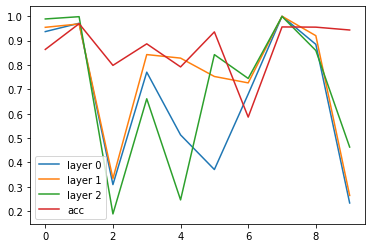

In [218]:
rlb_dict = dict()

acc_list = [correct_list[i] / counter_list[i] for i in range(class_num)]

for l in range(layer_num):
    rlb_dict[l] = []

for c in range(class_num):
    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    for l in range(layer_num):

        reliability = np.mean(np.array(trace_dict[c]['pos'])[:, l] == c)

        rlb_dict[l].append(reliability)  # haven't considered the weights from sample size yet

        print("class %d layer %d, reliability: %f" % (c, l, reliability))

plt.figure()
for l in range(layer_num):
    print("layer %d reliability: %f" % (l, np.sum(rlb_dict[l])))
    plt.plot(rlb_dict[l], label='layer '+str(l))
plt.plot(acc_list, label='acc')
plt.legend()

The reliability here indicates that, take class `0` for instance, `93.6979%` positive samples is predicted as '0' by the first layer. Likewise, `95.4588%` positive samples is predicted to be '0' on the second layer.

Note: Why the reliability of class 9 is so low but the acc is so high? Assumption: the similarity still needs improvement.

Layer 1 has the greatest reliability. So it's selected as the **Judge Layer**
- Question: can we take different layers so that at anytime the best reliability can be acchieved? 
- A: No, test sets are always unknown. But we can prefer a 'global' layer or 'problem-oriented' layer.

Before moving on, we can attempt to illustrate traces.

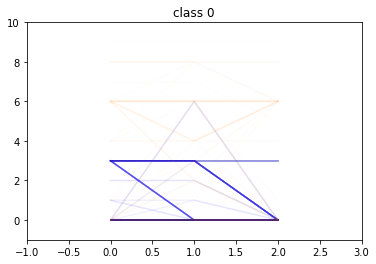

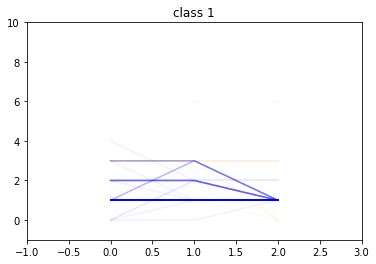

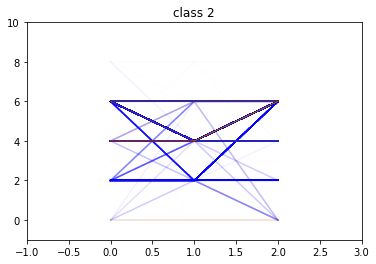

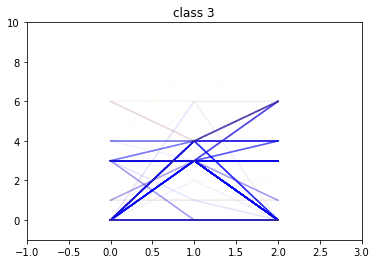

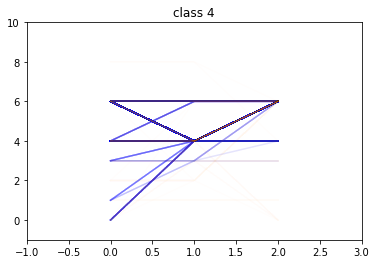

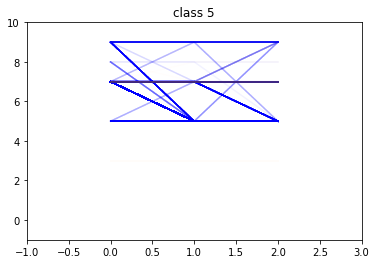

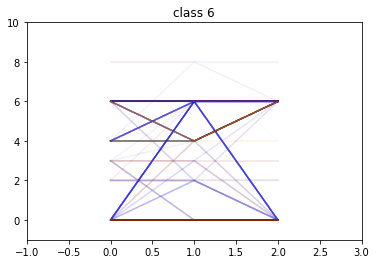

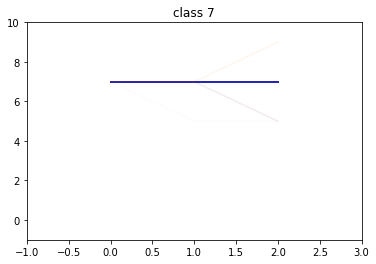

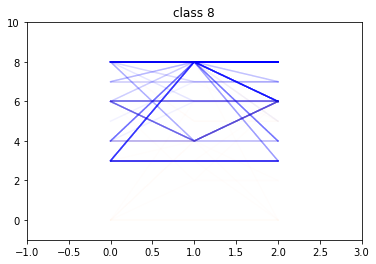

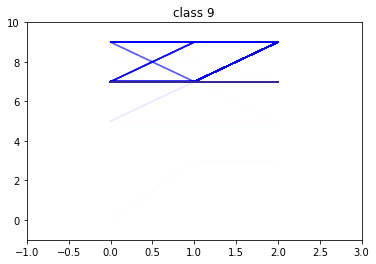

In [219]:
for c in range(class_num):
    fig = plt.figure()
    plt.title('class %d' % c)

    trace_pos = np.array(trace_dict[c]['pos'])
    trace_neg = np.array(trace_dict[c]['neg'])

    cl = ["blue", "orange"]
    alphas = [0.05, 0.01]
    for i, tcs in enumerate([trace_pos, trace_neg]):
        for tc in tcs:
            plt.plot(tc, color=cl[i], alpha=alphas[i])
            plt.xlim([-1, layer_num])
            plt.ylim([-1, class_num])

**What are we gonna do with the "Judge Layer"?**

One of the most intuitive methods is "What-I-Say-Goes".

But seperate judge layers is not accurate enough. We can combine multiple judge layers into the <mark>Jury</mark>

TODO: Count the top-k frequent traces for each class and represent them as decisive traces.

In [220]:
K = 5

In [260]:
def find_top_K_traces(traces, K):
    # counting
    size = [class_num] * layer_num
    cube = np.zeros(size)   # index is trace state
    for tc in traces:
        cube[tuple(tc)] += 1    

    c_d = dict()
    for i in range(class_num):
        for j in range(class_num):
            for k in range(class_num):
                if(cube[i][j][k] != 0):
                    c_d[cube[i][j][k]] = [i, j, k]

    # sorting
    od = OrderedDict(sorted(c_d.items(), reverse=True))

    # out
    ret = []
    cnt = 0
    for k, v in od.items():
        if cnt < K:
            ret.append(v)
            print(k, v)
            cnt += 1
        else: break
    
    return ret

In [263]:
for c in range(class_num):
    print("class %d: " % c)
    trace_pos = np.array(trace_dict[c]['pos'])
    top_tcs_pos = find_top_K_traces(trace_pos, K)

class 0: 
1007.0 [0, 0, 0]
31.0 [3, 3, 0]
21.0 [3, 0, 0]
11.0 [3, 3, 3]
2.0 [2, 2, 0]
class 1: 
1073.0 [1, 1, 1]
15.0 [2, 2, 1]
8.0 [3, 3, 1]
6.0 [1, 3, 1]
2.0 [2, 2, 2]
class 2: 
244.0 [6, 4, 6]
166.0 [2, 2, 2]
156.0 [4, 4, 6]
85.0 [2, 2, 6]
83.0 [6, 6, 6]
class 3: 
707.0 [3, 3, 3]
72.0 [3, 3, 0]
71.0 [0, 3, 0]
54.0 [0, 0, 0]
28.0 [0, 4, 0]
class 4: 
289.0 [4, 4, 6]
221.0 [6, 4, 6]
178.0 [4, 4, 4]
130.0 [6, 6, 6]
35.0 [6, 4, 4]
class 5: 
410.0 [5, 5, 5]
352.0 [7, 5, 5]
102.0 [7, 7, 5]
90.0 [7, 7, 7]
68.0 [9, 5, 5]
class 6: 
459.0 [6, 6, 6]
129.0 [0, 0, 0]
23.0 [4, 6, 6]
18.0 [6, 4, 6]
16.0 [4, 4, 6]
class 7: 
1154.0 [7, 7, 7]
1.0 [7, 7, 5]
class 8: 
956.0 [8, 8, 8]
37.0 [8, 8, 6]
33.0 [3, 3, 3]
19.0 [3, 8, 8]
17.0 [6, 6, 6]
class 9: 
589.0 [7, 7, 7]
239.0 [9, 9, 9]
201.0 [7, 7, 9]
53.0 [7, 9, 9]
16.0 [9, 7, 9]


In [265]:
for c in range(class_num):
    print("class %d: " % c)
    trace_neg = np.array(trace_dict[c]['neg'])
    top_tcs_neg = find_top_K_traces(trace_neg, K)

class 0: 
72.0 [0, 0, 0]
14.0 [3, 3, 3]
13.0 [6, 6, 6]
7.0 [6, 4, 6]
6.0 [3, 0, 0]
class 1: 
16.0 [3, 3, 3]
3.0 [3, 3, 1]
2.0 [6, 6, 6]
1.0 [4, 4, 0]
class 2: 
60.0 [4, 4, 6]
47.0 [6, 6, 6]
34.0 [6, 4, 6]
17.0 [0, 0, 0]
10.0 [4, 6, 6]
class 3: 
34.0 [0, 0, 0]
14.0 [0, 4, 6]
9.0 [6, 4, 6]
8.0 [4, 4, 6]
6.0 [6, 6, 6]
class 4: 
62.0 [6, 6, 6]
52.0 [6, 4, 6]
46.0 [4, 4, 6]
24.0 [4, 4, 4]
11.0 [0, 4, 6]
class 5: 
61.0 [7, 7, 7]
5.0 [9, 9, 9]
3.0 [3, 3, 3]
1.0 [8, 8, 8]
class 6: 
198.0 [0, 0, 0]
69.0 [6, 6, 6]
60.0 [6, 4, 6]
58.0 [4, 4, 6]
14.0 [3, 3, 0]
class 7: 
39.0 [7, 7, 7]
6.0 [7, 7, 9]
5.0 [7, 7, 5]
2.0 [7, 5, 5]
1.0 [8, 8, 8]
class 8: 
10.0 [6, 6, 6]
8.0 [6, 4, 6]
7.0 [3, 3, 3]
6.0 [4, 4, 6]
3.0 [8, 8, 5]
class 9: 
54.0 [7, 7, 7]
3.0 [9, 9, 9]
1.0 [9, 7, 7]


1. Pos from different class might have same trace
2. Neg might have same trace with Pos

- Pos from different class might have same trace
    - it doesn't matter, we're just picking tricky samples.
- Neg might have same trace with Pos
    - use probability?
    - find unique trace that exclusively belongs to neg?

# Start new from here

<mark>PRINCIPLE: Positive samples and negative samples are subjected to different distribution.</mark>

- get the benchmark feature map (with probabilistic method + a threshold? now the benchmark is mean)
- compare within training samples to calculate 'reliability' (reliability analysis)
- pick top-k reliable layers from $n$ candidates, these k layers are `judge layers`.